# Project 3 (Part 4) -  Romance vs Horror Reddit Classification (Modeling & Evaluation)

## Processes covered in this notebook

1. [Importing of datasets](#Importing-of-datasets)
2. [Establishing Baseline Accuracy](#Establishing-Baseline-Accuracy)
3. [Mapping subreddit](#Mapping-subreddit)
4. [Train Test Split](#Train-Test-Split)
5. [Creating Stemming & Lemmatizing Functions for RandomizedSearch](#Creating-Stemming-and-Lemmatizing-Functions-for-RandomizedSearch)
6. [Updating stopwords list with ones from EDA](#Updating-stopwords-list-with-ones-from-EDA)
7. [Implementing Pipeline & RandomizedSearch](#Implementing-Pipeline-&-RandomizedSearch)
8. [Using Multinomial Naive Bayes Classifier to help us draw inference](#Using-Multinomial-Naive-Bayes-Classifier-to-help-us-draw-inference)
9. [Evaluation of our Multinomial Naive Bayes Model](#Evaluation-of-our-Multinomial-Naive-Bayes-Model)

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_extraction import text
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize

## Importing of datasets

In [2]:
df = pd.read_csv('../datasets/horror&romance.csv')

In [3]:
df.head()

,selftext,subreddit
0,1. 500 Word Limit. All stories must be 500 wor...,shortscarystories
1,I was sitting on the soft snow with a blanket ...,shortscarystories
2,But the hatred that fills the room whenever he...,shortscarystories
3,I woke up hungry this morning. I've been sick ...,shortscarystories
4,I had seen school shootings on television in t...,shortscarystories


## Establishing Baseline Accuracy

In [4]:
df['subreddit'].value_counts()

shortscarystories    996
romance              873
Name: subreddit, dtype: int64

In [5]:
df['subreddit'].value_counts(normalize=True)

shortscarystories    0.532905
romance              0.467095
Name: subreddit, dtype: float64

In [6]:
print ('Short Scary Stories: ' + str(round((996/(996+874)*100),2)) + '%')
print ('Romance: ' + str(round((874/(874+996)*100),2)) + '%')

Short Scary Stories: 53.26%
Romance: 46.74%


**Baseline Accuraccy is: 53.26%**

## Mapping subreddit

_(shortscarystories - 1, romance - 0)_

In [7]:
df['subreddit'] = df['subreddit'].map({'shortscarystories':1, 'romance':0})
df.head()

,selftext,subreddit
0,1. 500 Word Limit. All stories must be 500 wor...,1
1,I was sitting on the soft snow with a blanket ...,1
2,But the hatred that fills the room whenever he...,1
3,I woke up hungry this morning. I've been sick ...,1
4,I had seen school shootings on television in t...,1


## Train Test Split

In [8]:
X = df['selftext']
y = df['subreddit']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=7)

In [10]:
#Checking strafication

print (y_train.value_counts(normalize=True)*100)

1    53.319058
0    46.680942
Name: subreddit, dtype: float64


## Creating Stemming and Lemmatizing Functions for RandomizedSearch

In [11]:
# Creating stemmer function for later use

def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9]", " ", str_input).lower().split() # Remove punctuation before stemming
    words = ' '.join(words) # Combining list of words again for second process
    words = re.sub(r"\s\w{1}\s", " ", words).lower().split() # Removing single (potentially typo) characters (e.g. 't', 'a', 'i', etc)
    words = [PorterStemmer().stem(word) for word in words]
    words = [word for word in words if re.match(r'\w{2,}', word)]
    return words

In [12]:
# Creating lemmatizer function for later use

def lemma_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9]", " ", str_input).lower().split() # Remove punctuation before stemming
    words = ' '.join(words) # Combining list of words again for second process
    words = re.sub(r"\s\w{1}\s", " ", words).lower().split() # Removing single (potentially typo) characters (e.g. 't', 'a', 'i', etc)
    words = [WordNetLemmatizer().lemmatize(word) for word in words]
    words = [word for word in words if re.match(r'\w{2,}', word)]
    return words

## Updating stopwords list with ones from EDA

In [13]:
# This is an iterative process where we come back to add in stopwords which were lacking 
# (warned by system in a previous iteration + through EDA)

updated_stop_words = text.ENGLISH_STOP_WORDS.union(['me', 'don', 'like', 'just', 'time', 'abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv', 'el', 'le', 'plea', 'u', 'anywh', 'becau', 'elsewh', 'everywh', 'ind', 'otherwi', 'somewh'])

## Implementing Pipeline & RandomizedSearch

### Implementing Pipeline & RandomizedSearch (TfidfVectorizer & Naive Bayes Classification)

In [14]:
NB_steps = [('tfidf', TfidfVectorizer()),
            ('NB', MultinomialNB())]

NB_pipeline = Pipeline(NB_steps)

In [15]:
parameters = {
    'tfidf__analyzer' : ["word"],
    'tfidf__ngram_range' : [(1,2), (1,1)],
    'tfidf__max_features' : [1000, 2000, 5000],
    'tfidf__min_df' : range(1,5),
    'tfidf__max_df' : np.linspace(0.9, 1, 5),
    'tfidf__stop_words' : [updated_stop_words],
    'tfidf__tokenizer' : [stemming_tokenizer, lemma_tokenizer]
}

In [16]:
rscv_MNB = RandomizedSearchCV(NB_pipeline, param_distributions=parameters, n_jobs=8, cv=5, verbose=1)

In [17]:
rscv_MNB.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   51.9s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:  1.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('tfidf',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                       

In [18]:
rscv_MNB.best_params_

{'tfidf__tokenizer': <function __main__.stemming_tokenizer(str_input)>,
 'tfidf__stop_words': frozenset({'a',
            'about',
            'abov',
            'above',
            'across',
            'after',
            'afterward',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alon',
            'alone',
            'along',
            'alreadi',
            'already',
            'also',
            'although',
            'alway',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'an',
            'and',
            'ani',
            'anoth',
            'another',
            'any',
            'anyhow',
            'anyon',
            'anyone',
            'anyth',
            'anything',
            'anyway',
            'anywh',
            'anywher',
            'anywhere',
            'are',
        

In [19]:
rscv_MNB.best_score_

0.939329050678087

In [20]:
opt_NB_steps = [('tfidf', TfidfVectorizer(analyzer="word", ngram_range=(1,1), min_df=4, max_features=5000, max_df=0.95, stop_words=updated_stop_words, tokenizer=lemma_tokenizer)),
                ('NB', MultinomialNB())]

opt_NB_pipeline = Pipeline(opt_NB_steps)

In [21]:
opt_NB_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.95, max_features=5000,
                                 min_df=4, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=frozenset({'a', 'about', 'abov',
                                                       'above', 'across',
                                                       'after', 'a...
                                                       'alreadi', 'already',
                                                       'also', 'although',
                                                       'alway', 'always', 'am',
                       

In [22]:
opt_NB_pipeline.score(X_test, y_test)

0.9316239316239316

### Implementing Pipeline & RandomizedSearch (TfidfVectorizer & RandomForest Classification)

In [23]:
rf_steps = [('tfidf', TfidfVectorizer()),
            ('rf', RandomForestClassifier())]

rf_pipeline = Pipeline(rf_steps)

In [24]:
rf_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'rf', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'rf__bootstrap', 'rf__class_weight', 'rf__criterion', 'rf__max_depth', 'rf__max_features', 'rf__max_leaf_nodes', 'rf__min_impurity_decrease', 'rf__min_impurity_split', 'rf__min_samples_leaf', 'rf__min_samples_split', 'rf__min_weight_fraction_leaf', 'rf__n_estimators', 'rf__n_jobs', 'rf__oob_score', 'rf__random_state', 'rf__verbose', 'rf__warm_start'])

In [25]:
parameters = {
    'tfidf__analyzer' : ["word"],
    'tfidf__ngram_range' : [(1,2), (1,1)],
    'tfidf__max_features' : [1000, 2000, 5000],
    'tfidf__min_df' : range(1,5),
    'tfidf__max_df' : np.linspace(0.9, 1, 5),
    'tfidf__stop_words' : [updated_stop_words],
    'tfidf__tokenizer' : [stemming_tokenizer, lemma_tokenizer],
    'rf__max_depth' : [5,10],
    'rf__n_estimators' : [50,100,150]
}

In [26]:
rscv_rf = RandomizedSearchCV(rf_pipeline, param_distributions=parameters, n_jobs=8, cv=5, verbose=1)

In [27]:
rscv_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('tfidf',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                       

In [28]:
rscv_rf.best_params_

{'tfidf__tokenizer': <function __main__.lemma_tokenizer(str_input)>,
 'tfidf__stop_words': frozenset({'a',
            'about',
            'abov',
            'above',
            'across',
            'after',
            'afterward',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alon',
            'alone',
            'along',
            'alreadi',
            'already',
            'also',
            'although',
            'alway',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'an',
            'and',
            'ani',
            'anoth',
            'another',
            'any',
            'anyhow',
            'anyon',
            'anyone',
            'anyth',
            'anything',
            'anyway',
            'anywh',
            'anywher',
            'anywhere',
            'are',
           

In [29]:
rscv_rf.best_score_

0.907209136331192

In [30]:
opt_rf_steps = [('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=3, max_features=2000, max_df=0.925, stop_words=updated_stop_words, tokenizer=stemming_tokenizer)),
                ('rf', RandomForestClassifier(n_estimators=100, max_depth=10))]

opt_rf_pipeline = Pipeline(opt_rf_steps)

In [31]:
opt_rf_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.925,
                                 max_features=2000, min_df=3,
                                 ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=frozenset({'a', 'about', 'abov',
                                                       'above', 'across',
                                                       'after', '...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=10,
                                        max_features='auto',
              

In [32]:
opt_rf_pipeline.score(X_test, y_test)

0.9102564102564102

Based on the randomized search of both models, it seems like the Multinomial Naive Bayes performs slightly better at approximately 93% to 94% accuracy and the RandomForest model yields a slightly lower accuracy of 91% to 93%. Both models perform significantly better than our baseline accuracy.

I will be using the Multinomial Naive Bayes model for subsequent evaluations.

## Using Multinomial Naive Bayes Classifier to help us draw inference

In [33]:
feat_list = []

for i in zip(opt_NB_pipeline.steps[0][1].get_feature_names(), opt_NB_pipeline.steps[1][1].coef_[0]):
    feat_list.append(i)

In [34]:
feature_importance = pd.DataFrame(feat_list, columns=['Words', 'Log Prob'])
feature_importance.sort_values(by=['Log Prob'], ascending=False, inplace=True)

In [35]:
feature_importance.head(10)

,Words,Log Prob
1436,eye,-6.099409
1196,door,-6.150998
2464,man,-6.313227
2667,night,-6.337655
2263,know,-6.399682
3333,room,-6.408069
1037,day,-6.416506
4096,thing,-6.463643
1128,didn,-6.498178
2852,people,-6.502723


Based on our model, the top 10 words which have the greatest impact in our classification of a text as Horror are:
1. eye
2. door
3. man
4. night
5. know
6. room
7. day
8. thing
9. didn
10. people

## Evaluation of our Multinomial Naive Bayes Model

### Getting our Confusion Matrix

In [36]:
tn, fp, fn, tp = confusion_matrix(y_test, opt_rf_pipeline.predict(X_test)).ravel()

In [37]:
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)

print ('Sensitivity: ' + str(round(sensitivity, 3)*100) + '%')
print ('Specificity: ' + str(round(specificity, 3)*100) + '%')

Sensitivity: 91.2%
Specificity: 90.9%


### Visualizing Probability Distribution

In [38]:
pred_proba = [i[1] for i in opt_NB_pipeline.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,'pred_probs':pred_proba})

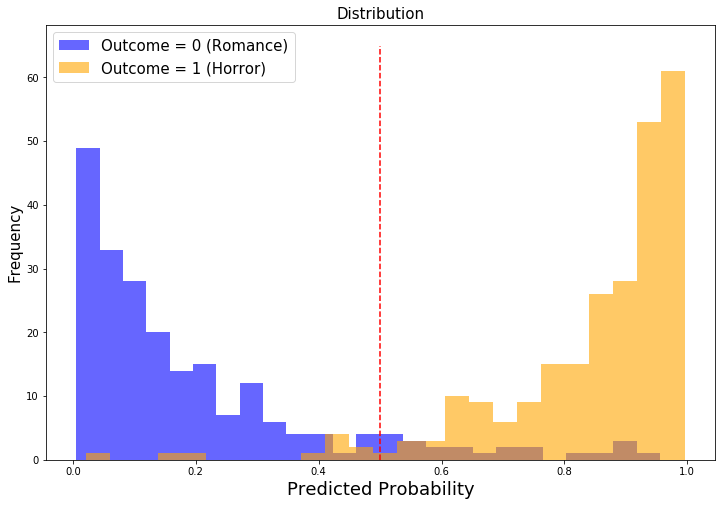

In [40]:
plt.figure(figsize = (12,8))
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0 (Romance)')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1 (Horror)')
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')
plt.title('Distribution', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Predicted Probability', fontsize=18)
plt.legend(fontsize=15);
plt.savefig('../images/outcome-predicted-probability-distribution.jpg')

### Visualizing AUC-ROC Curve

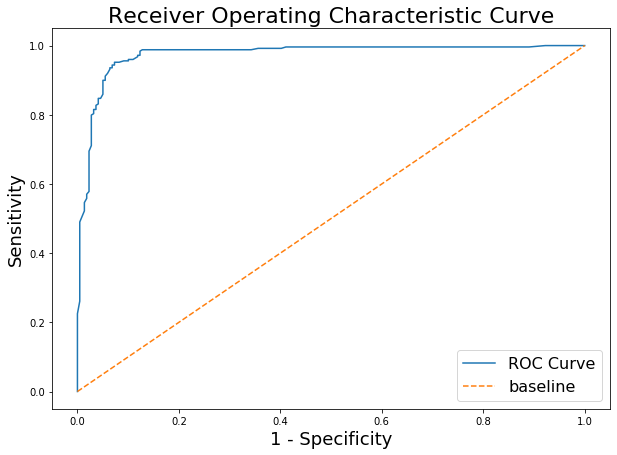

In [41]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

plt.savefig('../images/AUCROC.jpg')